## Analysing weather and TTC delay data from 2014 - 2018

    - Note to TTC and Toronto Open Data: Please save the city's data in CSV format. By saving 
    in xlsx format, you make it cumbersome to aggregate data (especially when some of the data is 
    encoded in utf-8 and others in latin-1!)

    - To see how I got to this stage, look at snow_delay for explanations on what the code does

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import requests
import json
import csv

In [2]:
weather_source = "weather_data/2014_2018_weather.csv"
weather_df = pd.read_csv(weather_source)
weather_df = weather_df[['Date/Time', 'Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]

weather_df = weather_df.rename(columns={'Date/Time':'date', 'Mean Temp (°C)':'temp', 'Total Precip (mm)':'precip', 'Snow on Grnd (cm)':'snow'})

# Convert date column into datetime format
weather_df['date'] = pd.to_datetime(weather_df.date)
weather_df = weather_df.set_index('date')
weather_df = weather_df.sort_values('date')
weather_df = weather_df.fillna(0)

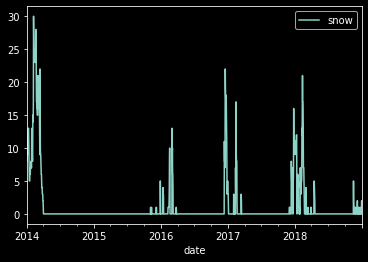

In [3]:
weather_df.plot(y='snow')

### Lots of missing snow data on 2015. This wasn't a parsing/encoding problem — the GOC reports missing values

### Lets load the TTC data

    - This time we are using both streetcar and bus delay data which will require
    a bit more processing to join and aggregate the two sources of data

In [21]:
fields = ['Report Date', 'Min Delay']

streetcar_delay_source = "ttc_data/2014_2018_streetcar.csv"
bus_delay_source = "ttc_data/2014_2018_bus.csv"

streetcar_df = pd.read_csv(streetcar_delay_source, usecols=fields)
streetcar_df['Report Date'] = pd.to_datetime(streetcar_df['Report Date'])

bus_df = pd.read_csv(bus_delay_source, usecols=fields)
bus_df['Report Date'] = pd.to_datetime(bus_df['Report Date'])



In [22]:
streetcar_df = streetcar_df.groupby(['Report Date']).sum()
streetcar_df = streetcar_df.sort_index()

bus_df = bus_df.groupby(['Report Date']).sum()
bus_df = bus_df.sort_index()

In [23]:
bus_df = bus_df.rename(columns={'Min Delay': 'Min Delay Bus'})

### Lets concatenate two data frames: bus delay and streetcar delay

In [24]:
combined_df = pd.concat([bus_df, streetcar_df], axis=1)
combined_df = pd.concat([bus_df, streetcar_df], axis=1)
combined_df = combined_df.fillna(0)

### Now let's create a new column with the sums of bus and streetcar delays to get a combined delay

In [25]:
combined_df['Combined Delay'] = combined_df['Min Delay Bus'] + combined_df['Min Delay']
combined_df = combined_df[['Combined Delay']]
combined_df[['Combined Delay']] = combined_df[['Combined Delay']] / 10

In [30]:
combined_df.mean()

Combined Delay    471.893264
dtype: float64

### Finally, lets do some plotting!

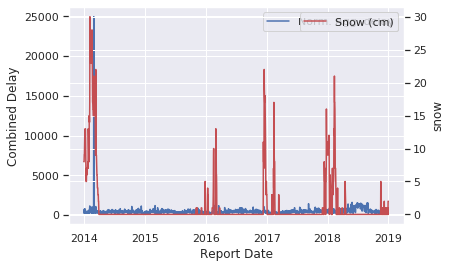

In [26]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

ax = sns.lineplot(x='Report Date', y='Combined Delay', data= combined_df.reset_index(), label='Norm. Agg. delay')

ax2 = ax.twinx()
ax2 = sns.lineplot(x='date', y='snow', data= weather_df.reset_index(), ax=ax2, color='r', label='Snow (cm)')

ax.legend()
plt.show()

### You can see that anomalous delay data in 2014 is throwing off the scale of the rest of the delay data
    - Lets verify the mean delay times to help scaling our graph

In [39]:
combined_df.loc['2014'].mean()
combined_df.loc['2018'].mean()
combined_df.loc[combined_df.idxmax()]

,Combined Delay
Report Date,
2014-03-01,24946.4


### Running the summary statistics showed that the mean is between 400 - 600 minutes
    - The max delay however was 24946 minutes in 2014... Was that a freak incident or a data error?

In [41]:
streetcar_df.loc['2014-03-01']
bus_df.loc['2014-03-01']

Min Delay Bus    249290.0
Name: 2014-03-01 00:00:00, dtype: float64

### Smells like a data error
    - A search of the TTC news website for March 3 2014 yielded no results (https://www.ttc.ca/News/2014/March/index.jsp)
    - Mighty Google search on March 2014 yields no results to point to a catastrophic breakdown on March 3 2014
    - Lets change the data to the mean of that month and note it down as a limitation

In [45]:
combined_df.loc['2014-03-01'] = combined_df.loc['2014-03'].mean()

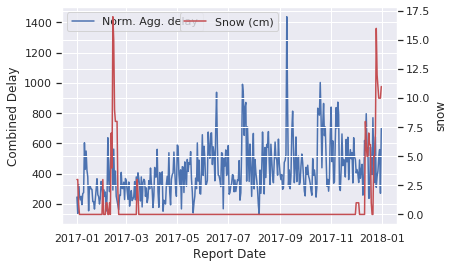

In [52]:
# Replotting based on new data

# Note how 'loc' is a super powerful operator that allows us to zoom in and out of the data!

ax = sns.lineplot(x='Report Date', y='Combined Delay', data= combined_df.loc['2017'].reset_index(), label='Norm. Agg. delay')

ax2 = ax.twinx()
ax2 = sns.lineplot(x='date', y='snow', data= weather_df.loc['2017'].reset_index(), ax=ax2, color='r', label='Snow (cm)')

ax.legend()
plt.show()

